# Donors Choose - Assignment T-SNE

In [2]:
# We must import sufficient libraries and functions to start out Analysis

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import os
import sqlite3
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from prettytable import PrettyTable

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()


C:\Desktop\Python\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Desktop\Python\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# We load the data of "Project" and "Resource".

project = pd.read_csv(r'C:\Users\Bharat Bhimshetty\Desktop\Python\Applied AI Course\Assignments\Assignment 2\train_data.csv')
resource = pd.read_csv(r'C:\Users\Bharat Bhimshetty\Desktop\Python\Applied AI Course\Assignments\Assignment 2\resources.csv')

In [4]:
# Checking the output for "project".

print('The Project dataset consists of ', project.shape[0],'datapoints and ',project.shape[1],'features')
print()
print('The list of features are: \n\n',project.columns.values)
print()
print('The sample Project Dataframe: \n')
project.head(3)

The Project dataset consists of  109248 datapoints and  17 features

The list of features are: 

 ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']

The sample Project Dataframe: 



Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   
2                    Health & Sports    Health & Wellness, Team Sports   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0

In [5]:
# Checking the output for "resource".

print('The Resource dataset consists of ', resource.shape[0],'datapoints and ',resource.shape[1],'features')
print()
print('The list of features are: \n\n',resource.columns.values)
print()
print('The sample Resource Dataframe: \n')
resource.head(3)

The Resource dataset consists of  1541272 datapoints and  4 features

The list of features are: 

 ['id' 'description' 'quantity' 'price']

The sample Resource Dataframe: 



id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   

    price  
0  149.00  
1   14.95  
2    8.45

# Data Analysis

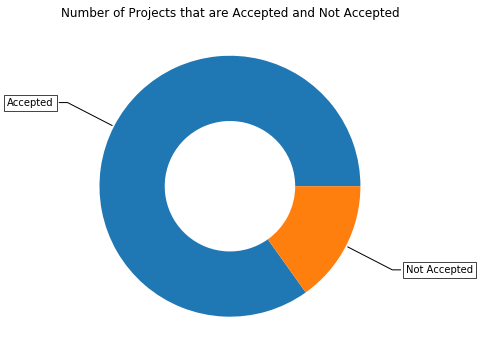

Projects Approved:  92706

Projects Not Approved:  16542

A total of 0.85% of Projects are Approved and 0.15% Projects are not Approved


In [6]:
# PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE.
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

plt.figure(figsize = (6,6))
recipe = ['Accepted', 'Not Accepted']
data = [92706, 16542]

wedges, text = plt.pie(data, wedgeprops=dict(width=0.5))

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

plt.title('Number of Projects that are Accepted and Not Accepted')
plt.show()

print('Projects Approved: ',project['project_is_approved'][project['project_is_approved'] == 1].count())
print()
print('Projects Not Approved: ',project['project_is_approved'][project['project_is_approved'] == 0].count())
print()
print('A total of {:.2f}% of Projects are Approved and {:.2f}% Projects are not Approved'.format(92706/(92706 + 16542), 16542 / (92706 + 16542)))

# 1.2.1  school_state

In [7]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

project_mean = project.groupby(project['school_state'])['project_is_approved'].agg(['mean']).reset_index()
print('States with Highest Project Approvals: \n\n', project_mean.sort_values('mean', ascending = False).head())
print()
print('States with Lowest Project Approvals: \n\n', project_mean.sort_values('mean', ascending = False).tail())

States with Highest Project Approvals: 

    school_state      mean
8            DE  0.897959
28           ND  0.888112
47           WA  0.876178
35           OH  0.875152
30           NH  0.873563

States with Lowest Project Approvals: 

    school_state      mean
18           LA  0.831245
26           MT  0.816327
43           TX  0.813142
7            DC  0.802326
46           VT  0.800000


In [8]:
# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = project_mean['school_state'],
        z = project_mean['mean'].astype(float),
        locationmode = 'USA-states',
        text = project_mean['school_state'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')

In [9]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html

def stack_plot(data, xtick, col2='project_is_approved', col3='count'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize = (20,8))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)
    
    plt.ylabel('Projects')
    plt.title('Projects Approved vs Not Approved')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('Count', 'Accepted'))
    plt.show()

In [10]:
# We define own functions for our ease.

def univariate_barplots(data, col1, col2 = 'project_is_approved', top = False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    # calculating sum of 1's in project_is_approved
    a = project.groupby(col1)[col2].agg(lambda x: x.eq(1).sum()).reset_index()
    a['mean'] = project.groupby(col1)[col2].agg(['mean']).reset_index()['mean']
    a['count'] = project.groupby(col1)[col2].agg(['count']).reset_index()['count']
    
    a.sort_values(by = 'count', ascending = False, inplace=True)
    
    if top:
        a = a[0:top]
        
    stack_plot(a, xtick = col1, col2=col2, col3='count')
    print('These are top 5 values: \n\n',a.head())
    print()
    print('These are bottom 5 values: \n\n',a.tail())

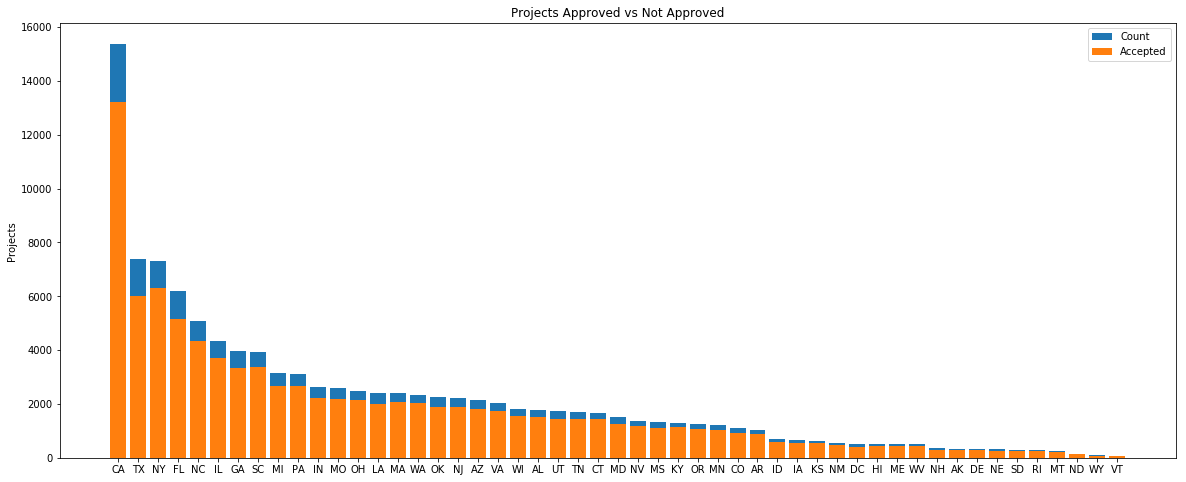

These are top 5 values: 

    school_state  project_is_approved      mean  count
4            CA                13205  0.858136  15388
43           TX                 6014  0.813142   7396
34           NY                 6291  0.859661   7318
9            FL                 5144  0.831690   6185
27           NC                 4353  0.855038   5091

These are bottom 5 values: 

    school_state  project_is_approved      mean  count
39           RI                  243  0.852632    285
26           MT                  200  0.816327    245
28           ND                  127  0.888112    143
50           WY                   82  0.836735     98
46           VT                   64  0.800000     80


In [11]:
univariate_barplots(project, col1 = 'school_state', col2 = 'project_is_approved', top=False)

### Observations
* Projects for every state has an average approval of 80%. 
* Most projects are approved for California State at 14.25% on the whole with a submission count of 14%.
* Least Projects are approved for Vermont State. 

# 1.2.2 : teacher_prefix

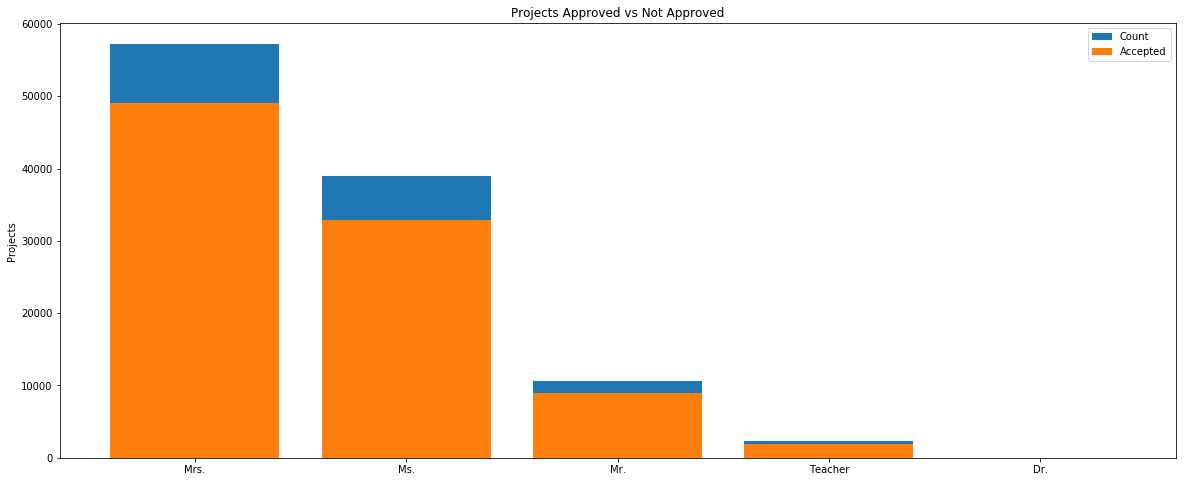

These are top 5 values: 

   teacher_prefix  project_is_approved      mean  count
2           Mrs.                48997  0.855559  57269
3            Ms.                32860  0.843537  38955
1            Mr.                 8960  0.841473  10648
4        Teacher                 1877  0.795339   2360
0            Dr.                    9  0.692308     13

These are bottom 5 values: 

   teacher_prefix  project_is_approved      mean  count
2           Mrs.                48997  0.855559  57269
3            Ms.                32860  0.843537  38955
1            Mr.                 8960  0.841473  10648
4        Teacher                 1877  0.795339   2360
0            Dr.                    9  0.692308     13


In [12]:
univariate_barplots(project, col1 = 'teacher_prefix')

### Observations
* The approval percentage of projects are higher for married woman almost at 53% and submission count at 52.5%.
* It seems that female teachers submission of projects are almost higher appx (75%) compared to male teachers.

# 1.2.3 : project_grade_category

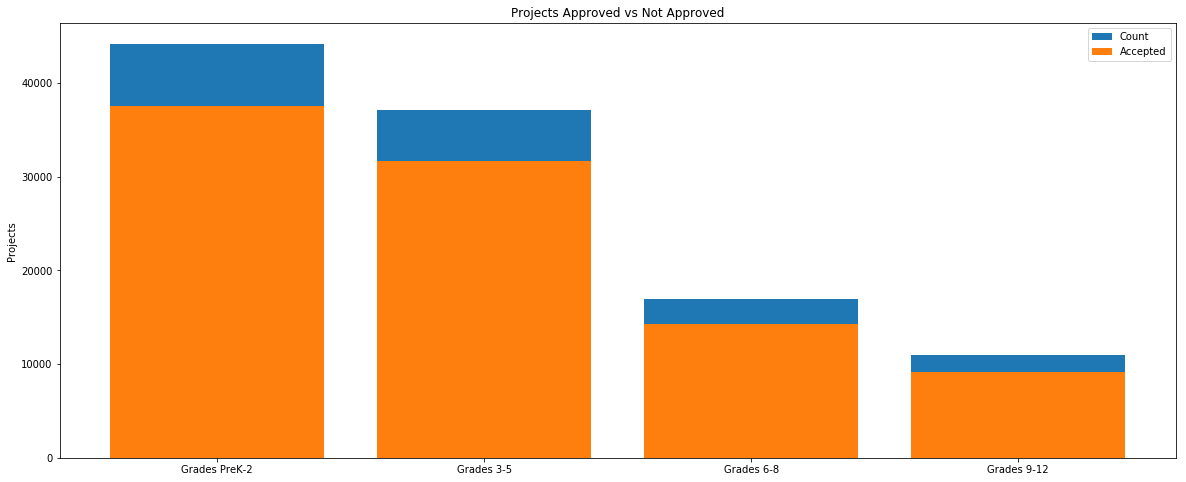

These are top 5 values: 

   project_grade_category  project_is_approved      mean  count
3          Grades PreK-2                37536  0.848751  44225
0             Grades 3-5                31729  0.854377  37137
1             Grades 6-8                14258  0.842522  16923
2            Grades 9-12                 9183  0.837636  10963

These are bottom 5 values: 

   project_grade_category  project_is_approved      mean  count
3          Grades PreK-2                37536  0.848751  44225
0             Grades 3-5                31729  0.854377  37137
1             Grades 6-8                14258  0.842522  16923
2            Grades 9-12                 9183  0.837636  10963


In [13]:
univariate_barplots(project, col1 = 'project_grade_category')

### Observations
* Approved projects are higher for PreK-2 at 40.5% on the whole and submission count at 40.5% on the whole.
* Almost 40.5% of projects submitted are by PreK-2 and are approved at 100% success rate.
* Donors Choose Org does gives atmost importance to projects of PreK-2 Grades at 100% approval chance.
* We can observe least projects approved are for 9-12 Grades which is in proportion to their submission count.

# 1.2.4 : project_subject_categories

In [14]:
project['project_subject_categories'].head(8)

0                    Literacy & Language
1      History & Civics, Health & Sports
2                        Health & Sports
3    Literacy & Language, Math & Science
4                         Math & Science
5     Literacy & Language, Special Needs
6     Literacy & Language, Special Needs
7                         Math & Science
Name: project_subject_categories, dtype: object

In [15]:
# designed by me and not copied
# we filter the data by removing some spl chars

psc = []
for i in project['project_subject_categories']:
    i = i.replace('&','_').replace(' ','').replace(',',' ')
    psc.append(i)

In [16]:
# A new column is created.

project['project_subject_cleaned_categories'] = psc

In [17]:
project['project_subject_cleaned_categories'].head()

0                 Literacy_Language
1      History_Civics Health_Sports
2                     Health_Sports
3    Literacy_Language Math_Science
4                      Math_Science
Name: project_subject_cleaned_categories, dtype: object

In [18]:
# we drop existing column.

project.drop(['project_subject_categories'], axis=1, inplace= True)

In [19]:
project.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

  project_subject_cleaned_categories  
0                  Literacy_Language  
1       History_Civics Health_Sports

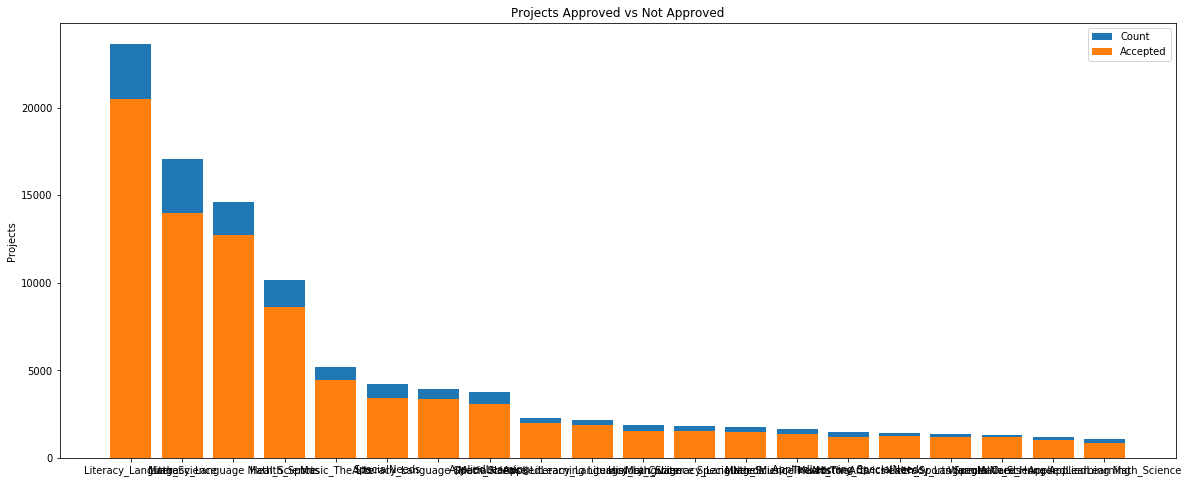

These are top 5 values: 

    project_subject_cleaned_categories  project_is_approved      mean  count
24                  Literacy_Language                20520  0.867470  23655
32                       Math_Science                13991  0.819529  17072
28     Literacy_Language Math_Science                12725  0.869432  14636
8                       Health_Sports                 8640  0.848973  10177
40                      Music_TheArts                 4429  0.855019   5180

These are bottom 5 values: 

    project_subject_cleaned_categories  project_is_approved      mean  count
19   History_Civics Literacy_Language                 1271  0.894441   1421
14         Health_Sports SpecialNeeds                 1215  0.873472   1391
50                 Warmth Care_Hunger                 1212  0.925898   1309
33       Math_Science AppliedLearning                 1019  0.835246   1220
4        AppliedLearning Math_Science                  855  0.812738   1052


In [20]:
univariate_barplots(project, col1 = 'project_subject_cleaned_categories', top=20)

In [21]:
# count all words in corpus https://stackoverflow.com/a/22898595/4084039

psc_counter = Counter()
for i in project['project_subject_cleaned_categories']:
    psc_counter.update(i.split())

In [22]:
print(psc_counter)

Counter({'Literacy_Language': 52239, 'Math_Science': 41421, 'Health_Sports': 14223, 'SpecialNeeds': 13642, 'AppliedLearning': 12135, 'Music_TheArts': 10293, 'History_Civics': 5914, 'Warmth': 1388, 'Care_Hunger': 1388})


In [23]:
print(sum(psc_counter.values()))

152643


{'Literacy_Language': 52239, 'Math_Science': 41421, 'Health_Sports': 14223, 'SpecialNeeds': 13642, 'AppliedLearning': 12135, 'Music_TheArts': 10293, 'History_Civics': 5914, 'Warmth': 1388, 'Care_Hunger': 1388}

length of items in sorted sub category:  9


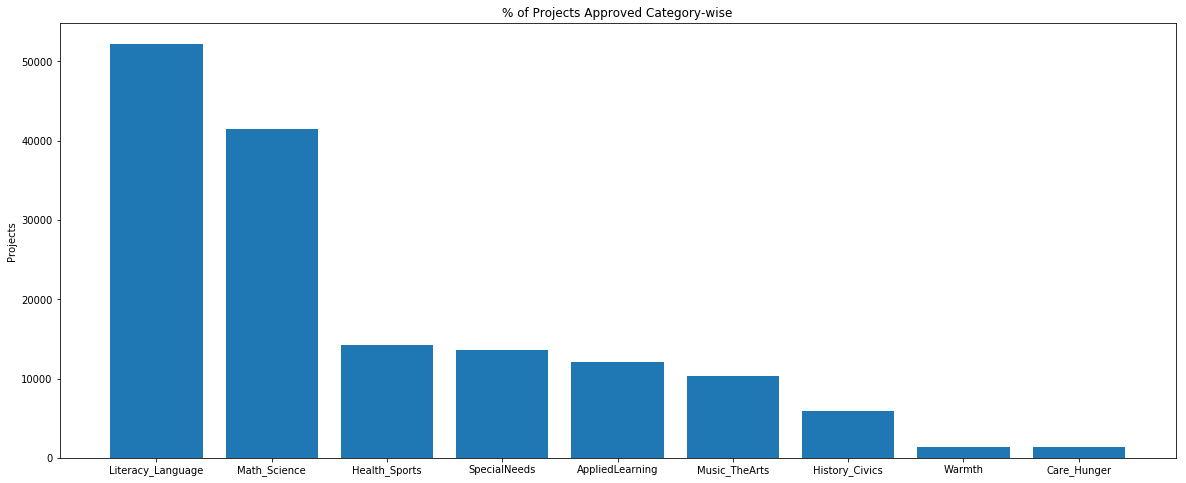

In [24]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039

"""my_counter is converted to dict and we extract values of items, then we sort, 
and we make dictionary words as key and its occurences as values.
"""
sorted_sub_cat_dict = dict(sorted(dict(psc_counter).items(), key = lambda kv:kv[1], reverse = True)) 

print(sorted_sub_cat_dict)
print()
print('length of items in sorted sub category: ',len(sorted_sub_cat_dict))
plt.figure(figsize = (20,8))
p1 = plt.bar(range(len(sorted_sub_cat_dict)), list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of Projects Approved Category-wise')
plt.xticks(range(len(sorted_sub_cat_dict)), list(sorted_sub_cat_dict.keys()))
plt.show()

### Observations
* "Literacy_Language" subject has occupied 22% of total approved projects which is highest and at submission count of 21.65%.
* Least project approvals are for binary category of "AppliedLearning Math_science" at almost at 1%.
* Literacy_Language subject share occupies at 34% [52239/152643], both single as well as binary (combined with other sub).
* Care_Hunger subject is least at almost 1%.

# 1.2.5 project_subject_subcategories

In [25]:
project['project_subject_subcategories'].head(8)

0                          ESL, Literacy
1       Civics & Government, Team Sports
2         Health & Wellness, Team Sports
3                  Literacy, Mathematics
4                            Mathematics
5    Literature & Writing, Special Needs
6                Literacy, Special Needs
7                            Mathematics
Name: project_subject_subcategories, dtype: object

In [26]:
# we filter the data by removing some spl chars

pssc = []
for i in project['project_subject_subcategories']:
    i = i.replace('&','_').replace(' ','').replace(',',' ')
    pssc.append(i)

In [27]:
# A new column is created.

project['project_subject_cleaned_subcategories'] = pssc

In [28]:
project['project_subject_cleaned_subcategories'].head(8)

0                       ESL Literacy
1       Civics_Government TeamSports
2         Health_Wellness TeamSports
3               Literacy Mathematics
4                        Mathematics
5    Literature_Writing SpecialNeeds
6              Literacy SpecialNeeds
7                        Mathematics
Name: project_subject_cleaned_subcategories, dtype: object

In [29]:
# We drop existing column.

project.drop(['project_subject_subcategories'], axis=1, inplace=True)

In [30]:
project.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   

  project_subject_cleaned_categories project_subject_cleaned_subcategories  
0                  Literacy_Language                          ESL Literacy  
1       History_Civics Health_Sports          Civics_Government TeamSports  
2                      Health_Sports            Health_Wellness TeamSports

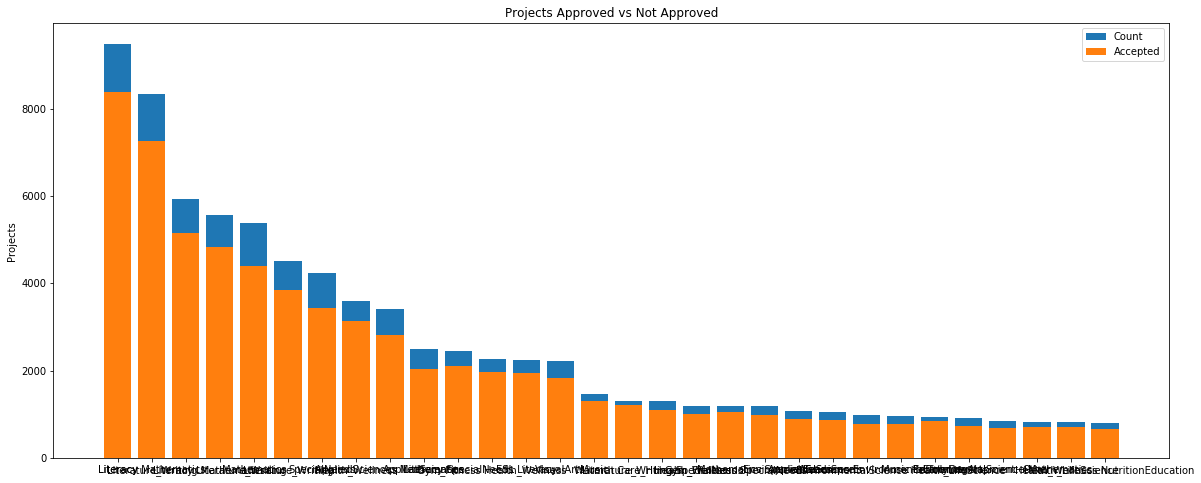

These are top 5 values: 

     project_subject_cleaned_subcategories  project_is_approved      mean  \
317                              Literacy                 8371  0.882458   
319                  Literacy Mathematics                 7260  0.872072   
331        Literature_Writing Mathematics                 5140  0.867803   
318           Literacy Literature_Writing                 4823  0.865733   
342                           Mathematics                 4385  0.815207   

     count  
317   9486  
319   8325  
331   5923  
318   5571  
342   5379  

These are bottom 5 values: 

     project_subject_cleaned_subcategories  project_is_approved      mean  \
150                      EarlyDevelopment                  740  0.817680   
198      EnvironmentalScience Mathematics                  683  0.815036   
368                                 Other                  701  0.843562   
273                    Health_LifeScience                  701  0.847642   
295    Health_Wellness Nutr

In [31]:
univariate_barplots(project, col1 = 'project_subject_cleaned_subcategories', top=30)

In [32]:
# count all words in corpus https://stackoverflow.com/a/22898595/4084039

pssc_counter = Counter()
for i in project['project_subject_cleaned_subcategories']:
    pssc_counter.update(i.split())

In [33]:
# Checking the output.

print(pssc_counter)

Counter({'Literacy': 33700, 'Mathematics': 28074, 'Literature_Writing': 22179, 'SpecialNeeds': 13642, 'AppliedSciences': 10816, 'Health_Wellness': 10234, 'VisualArts': 6278, 'EnvironmentalScience': 5591, 'Gym_Fitness': 4509, 'ESL': 4367, 'EarlyDevelopment': 4254, 'Health_LifeScience': 4235, 'History_Geography': 3171, 'Music': 3145, 'College_CareerPrep': 2568, 'Other': 2372, 'TeamSports': 2192, 'CharacterEducation': 2065, 'PerformingArts': 1961, 'SocialSciences': 1920, 'Warmth': 1388, 'Care_Hunger': 1388, 'NutritionEducation': 1355, 'ForeignLanguages': 890, 'Civics_Government': 815, 'Extracurricular': 810, 'ParentInvolvement': 677, 'FinancialLiteracy': 568, 'CommunityService': 441, 'Economics': 269})


In [34]:
sum(pssc_counter.values())

175874

{'Literacy': 33700, 'Mathematics': 28074, 'Literature_Writing': 22179, 'SpecialNeeds': 13642, 'AppliedSciences': 10816, 'Health_Wellness': 10234, 'VisualArts': 6278, 'EnvironmentalScience': 5591, 'Gym_Fitness': 4509, 'ESL': 4367, 'EarlyDevelopment': 4254, 'Health_LifeScience': 4235, 'History_Geography': 3171, 'Music': 3145, 'College_CareerPrep': 2568, 'Other': 2372, 'TeamSports': 2192, 'CharacterEducation': 2065, 'PerformingArts': 1961, 'SocialSciences': 1920, 'Warmth': 1388, 'Care_Hunger': 1388, 'NutritionEducation': 1355, 'ForeignLanguages': 890, 'Civics_Government': 815, 'Extracurricular': 810, 'ParentInvolvement': 677, 'FinancialLiteracy': 568, 'CommunityService': 441, 'Economics': 269}

length of items in sorted sub category:  30


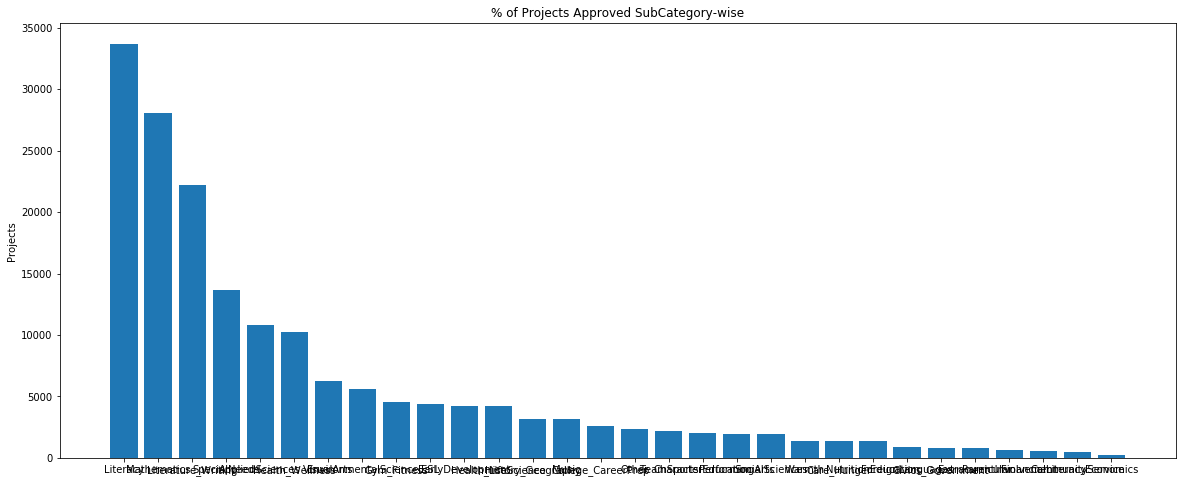

In [35]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039

"""my_counter is converted to dict and we extract values of items, then we sort, 
and we make dictionary words as key and its occurences as values.
"""
sorted_sub_subcat_dict = dict(sorted(dict(pssc_counter).items(), key = lambda kv:kv[1], reverse = True)) 

print(sorted_sub_subcat_dict)
print()
print('length of items in sorted sub category: ',len(sorted_sub_subcat_dict))
plt.figure(figsize = (20,8))
p1 = plt.bar(range(len(sorted_sub_subcat_dict)), list(sorted_sub_subcat_dict.values()))

plt.ylabel('Projects')
plt.title('% of Projects Approved SubCategory-wise')
plt.xticks(range(len(sorted_sub_subcat_dict)), sorted_sub_subcat_dict.keys())
plt.show()

### Observations
* Literacy considered in solo, occupies 9% of subcategory in approval projects.
* Health_Wellness NutritionEducation together occupies less than 1%.
* Literacy when divided all subcategories individually occupies highest share of 19% [33700/175874].


# 1.2.6 project_title (Text features) 

In [36]:
project['project_title'].head(2)

0    Educational Support for English Learners at Home
1               Wanted: Projector for Hungry Learners
Name: project_title, dtype: object

In [37]:
# we filter the data by removing some spl chars.

pt = []
for i in project['project_title'][:]:
    j = i.split()
    pt.append(len(j))

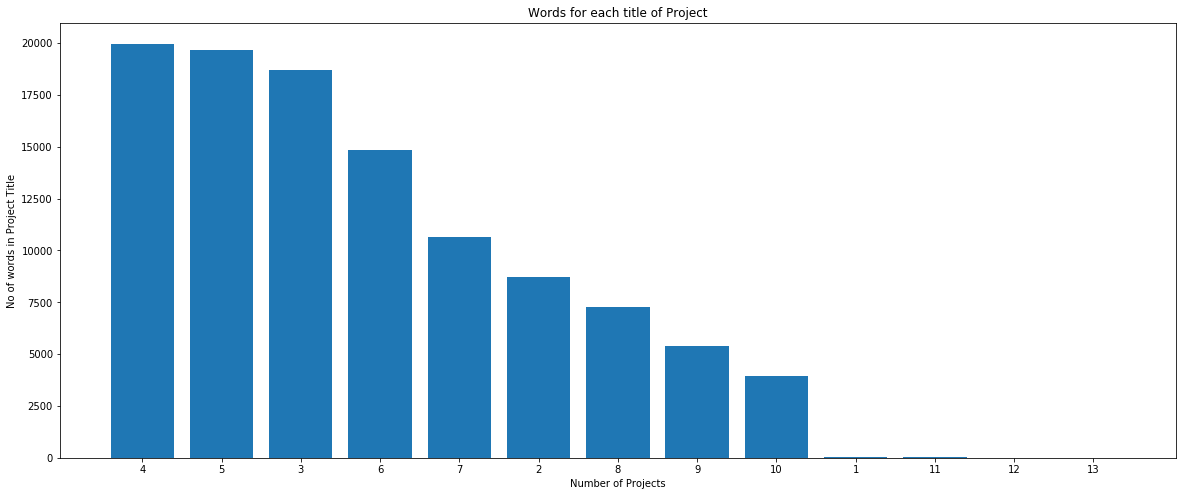

In [38]:
p_t = dict(sorted(dict(Counter(pt)).items(), key = lambda kv:kv[1], reverse = True)) 

plt.figure(figsize=(20,8))
plt.bar(range(len(p_t)), list(p_t.values()))

plt.ylabel('No of words in Project Title')
plt.xlabel('Number of Projects')
plt.title('Words for each title of Project')
plt.xticks(range(len(p_t)), list(p_t.keys()))
plt.show()

In [39]:
project.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   

  project_subject_cleaned_categories project_subject_cleaned_subcategories  
0                  Literacy_Language                          ESL Literacy

In [40]:
# Word count of "project_title" where project got approved".

approved_title_word_count = []
for i in project['project_title'][project['project_is_approved'] == 1][:]:
    j = i.split()
    approved_title_word_count.append(len(j))

In [41]:
# Word count of "project_title" where project not approved".

not_approved_title_word_count = []
for i in project['project_title'][project['project_is_approved'] == 0][:]:
    j = i.split()
    not_approved_title_word_count.append(len(j))

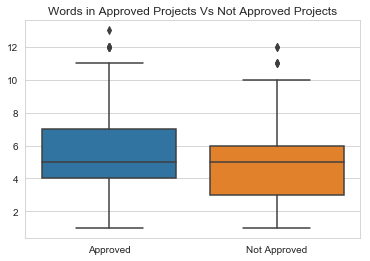

In [42]:
# Boxplot.

sns.set_style('whitegrid')
sns.boxplot(data = [approved_title_word_count, not_approved_title_word_count])
plt.title('Words in Approved Projects Vs Not Approved Projects')
plt.xticks([0,1], ('Approved', 'Not Approved'))
plt.show()

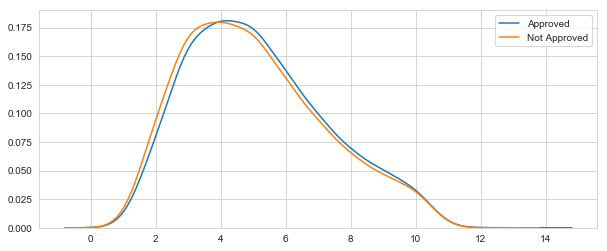

In [43]:
# Kernal density estimation plot.

plt.figure(figsize = (10,4))
sns.kdeplot(approved_title_word_count, bw = 0.6, label = 'Approved')
sns.kdeplot(not_approved_title_word_count, bw = 0.6, label = 'Not Approved')
plt.legend()
plt.show()

In [44]:
# https://stackoverflow.com/a/2258273/10219869

pt_dict = dict(Counter(pt))
print(sorted(pt_dict.items(), key = lambda x:x[1], reverse = True))

[(4, 19979), (5, 19677), (3, 18691), (6, 14824), (7, 10631), (2, 8733), (8, 7289), (9, 5383), (10, 3968), (1, 31), (11, 30), (12, 11), (13, 1)]


### Observations
* The 4 letter title is highest at 18.28%.
* the 1 letter title and 11, 12 and 13 letter titles are countable which add to miniscule 73.
* We can observe the approved title count IQR is for 4-7 title range and non approved IQR for 3-6 range.
* The kde plot peak is at 4 which is highest.

# 1.2.7 project_essays (total 4)

In [45]:
# We combine all 4 essay features to one feature 'essay'

project['essay'] = project['project_essay_1'].map(str) + project['project_essay_2'].map(str) + project['project_essay_3'].map(str) + project['project_essay_4'].map(str)

In [46]:
project['essay'].head()

0    My students are English learners that are work...
1    Our students arrive to our school eager to lea...
2    \r\n\"True champions aren't always the ones th...
3    I work at a unique school filled with both ESL...
4    Our second grade classroom next year will be m...
Name: essay, dtype: object

In [47]:
# Word count of "Essay" where project got approved.

approved_essay_word_count = []
for i in project['essay'][project['project_is_approved'] == 1][:]:
    j = i.split()
    approved_essay_word_count.append(len(j))

In [48]:
# Word count of "Essay" where project not approved.

not_approved_essay_word_count = []
for i in project['essay'][project['project_is_approved'] == 0][:]:
    j = i.split()
    not_approved_essay_word_count.append(len(j))

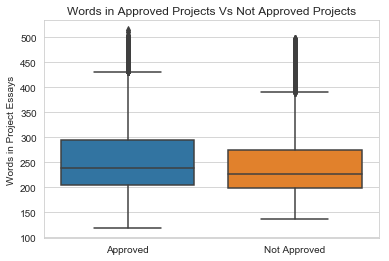

In [49]:
# Boxplot.

sns.boxplot(data = [approved_essay_word_count, not_approved_essay_word_count])
plt.title('Words in Approved Projects Vs Not Approved Projects')
plt.ylabel('Words in Project Essays')
plt.xticks([0,1], ('Approved', 'Not Approved'))
plt.show()

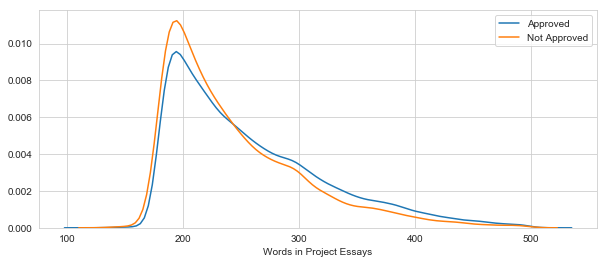

In [50]:
# Kernal density estimation plot.

plt.figure(figsize = (10,4))
sns.distplot(approved_essay_word_count, hist=False, label = 'Approved')
sns.distplot(not_approved_essay_word_count, hist=False, label = 'Not Approved')
plt.xlabel('Words in Project Essays')
plt.legend()
plt.show()

### Observations
* The Box plot IQR for approved essay words are in between 200 and 300 appx, and for non approved it is 200-275 appx.
* In the dist plot we can see the peak at 190 appx for both approved and non approved projects.
* The words per essay count range between 160 appx to 530 appx.

# 1.2.8 cost_per_project

In [51]:
resource_data = resource.groupby('id').agg('sum').reset_index()
resource_data.head()

id  quantity    price
0  p000001         7   459.56
1  p000002        21   515.89
2  p000003         4   298.97
3  p000004        98  1113.69
4  p000005         8   485.99

In [52]:
print('Min Price:', resource_data['price'].min())
print()
print('Max Price: ', resource_data['price'].max())

Min Price: 0.66

Max Price:  9999.0


In [53]:
# Merging both df's

project_resource = pd.merge(project, resource_data, on = 'id')

In [54]:
project_resource.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

  project_subject_cleaned_categories project_subject_cleaned_subcategories  \
0                  Literacy_Language                          ESL Literacy   
1       History_Civics Health_Sports          Civics_Government TeamSports   

                                               essay  quantity  price  
0  My students are English learners that are work...        23  154.6  
1  Our students arrive to our school eager to lea...         1  299.0

In [55]:
# Price where project got approved.

approved_price = list(project_resource['price'][project_resource['project_is_approved'] == 1])

# Price where project got approved.

not_approved_price = list(project_resource['price'][project_resource['project_is_approved'] == 0])

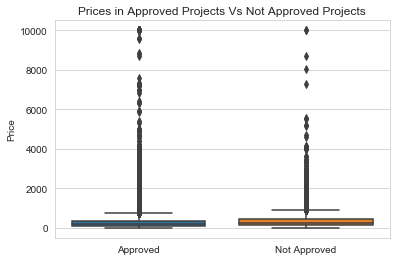

In [56]:
# Boxplot.

sns.boxplot(data = [approved_price, not_approved_price])
plt.title('Prices in Approved Projects Vs Not Approved Projects')
plt.xticks([0,1], ('Approved', 'Not Approved'))
plt.ylabel('Price')
plt.show()

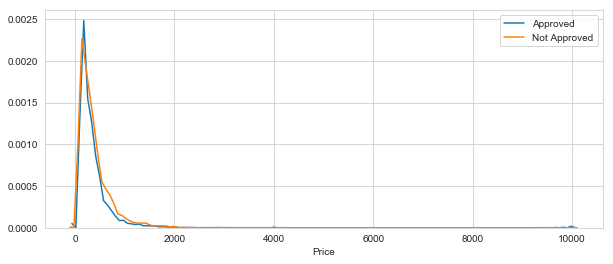

In [57]:
# Kernal density estimation plot.

plt.figure(figsize = (10,4))
sns.distplot(approved_price, hist=False, label = 'Approved')
sns.distplot(not_approved_price, hist=False, label = 'Not Approved')
plt.xlabel('Price')
plt.legend()
plt.show()

In [58]:
# Table with contents "percentile","approved projects","unapproved projects".

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i, np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(not_approved_price,i),  3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

### Observations
* We can see the Highest price is '9999.0' and lowest is 0.66.
* Based on box plot the price IQR of approved projects is '266.125' and for non approved projects '309.053'.
* By the distplot we can see the graph is right skewed meaning the peak is at median which is at 199.

# 1.2.9 teacher_number_of_previously_posted_projects

In [59]:
# We create a list.

tnppp = []
for i in project['teacher_number_of_previously_posted_projects'][:]:
    tnppp.append(i)

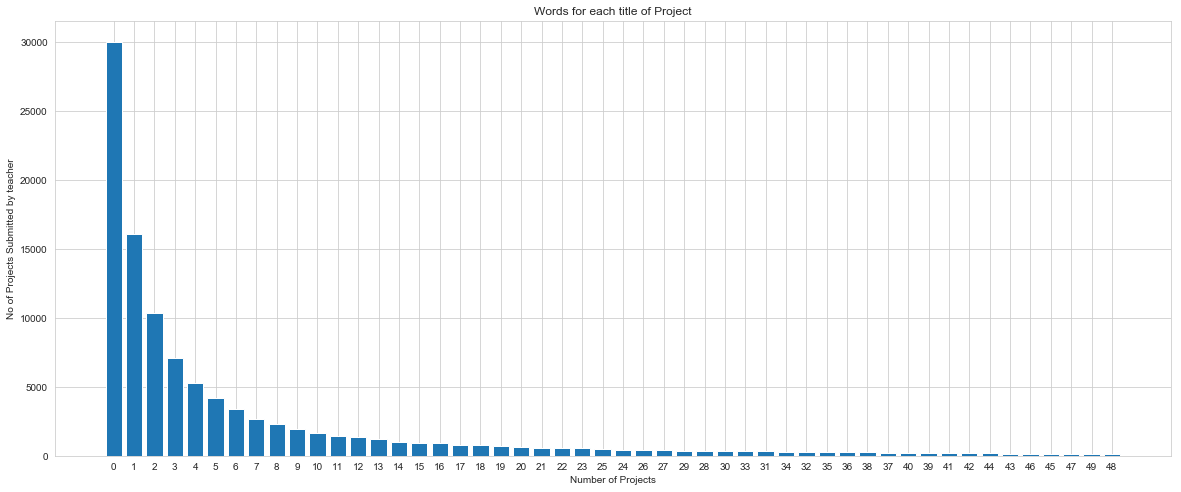

In [60]:
# We are considering top 50 submits wherein the highest is at 30014 and 50th is at 140  using this command (Counter(tnppp).most_common(50))

tnppp = dict(sorted(dict(Counter(tnppp)).items(), key = lambda kv:kv[1], reverse = True)) 

plt.figure(figsize=(20,8))
plt.bar(range(50), list(tnppp.values())[:50])

plt.ylabel('No of Projects Submitted by teacher')
plt.xlabel('Number of Projects')
plt.title('Words for each title of Project')
plt.xticks(range(50), list(tnppp.keys())[:50])
plt.show()

In [61]:
# previously posted projects for teachers where project got approved.

approved_posted_projects = []
for i in project['teacher_number_of_previously_posted_projects'][project['project_is_approved'] == 1][:]:
    approved_posted_projects.append(i)

In [62]:
# previously posted projects for teachers where project not approved.

not_approved_posted_projects = []
for i in project['teacher_number_of_previously_posted_projects'][project['project_is_approved'] == 0][:]:
    not_approved_posted_projects.append(i)

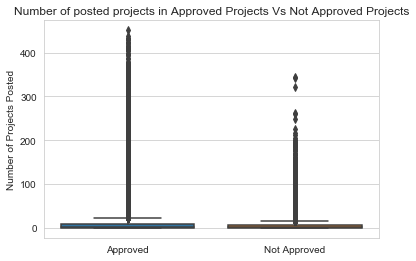

In [63]:
# Boxplot.

sns.boxplot(data = [approved_posted_projects, not_approved_posted_projects])
plt.title('Number of posted projects in Approved Projects Vs Not Approved Projects')
plt.xticks([0,1], ('Approved', 'Not Approved'))
plt.ylabel('Number of Projects Posted')
plt.show()

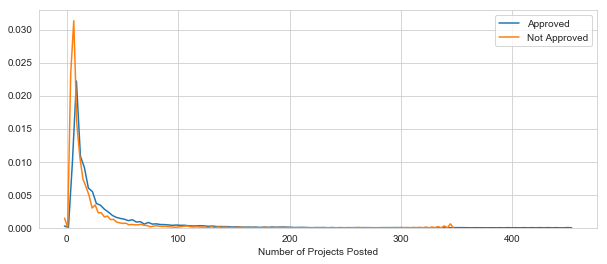

In [64]:
# Kernal density estimation plot.

plt.figure(figsize = (10,4))
sns.distplot(approved_posted_projects, hist=False, label = 'Approved')
sns.distplot(not_approved_posted_projects, hist=False, label = 'Not Approved')
plt.xlabel('Number of Projects Posted')
plt.legend()
plt.show()

### Observations
* Based on distplot the graph is right skewed peak is at median which is at 140
* The highest is o at 30,014 wherein these are first time submitted projects.

# 1.2.10 project_resource_summary

In [65]:
project['project_resource_summary'].head(3)

0    My students need opportunities to practice beg...
1    My students need a projector to help with view...
2    My students need shine guards, athletic socks,...
Name: project_resource_summary, dtype: object

In [66]:
# we can find that almost all numbers are present atleast more than 2000 rows..!!

print('number 6 in',project['project_resource_summary'][project['project_resource_summary'].str.contains('6')].count(), 'rows')
print()
print('number 4 in',project['project_resource_summary'][project['project_resource_summary'].str.contains('4')].count(), 'rows')

number 6 in 1957 rows

number 4 in 2479 rows


In [67]:
from bs4 import BeautifulSoup 
import contractions 
import re

sw = set(stopwords.words('english'))

def clean_sentence(text):
    text = BeautifulSoup(text, 'lxml').get_text()           # removes html tags such as <br />
    text = text.lower()                                     # converts text to lower case
    text = contractions.fix(text)                           # converts (don't) to (do not)
    text = re.sub('\W+',' ',text)                           # removes all special chars, punc
    text = text.split() 
    text1 = []
    for i in text:
        if "_" in i:
            del i                                           # removes string if it contains '_'
        else:
            text1.append(i)
    text = " ".join(text1)
    text = text.replace(' ','')
    return text

In [68]:
# attaching the list to variable 'prs' temporarily wherein 'prs' is cleaned text for 'project_resource_summary'

prs = [clean_sentence(i) for i in project['project_resource_summary']] 

In [69]:
prs[:2]

['mystudentsneedopportunitiestopracticebeginningreadingskillsinenglishathome',
 'mystudentsneedaprojectortohelpwithviewingeducationalprograms']

In [70]:
# if there is a num in summary then we append it as 1 else 0
num_prs = []
for i in prs:
    if i.isalpha():
        num_prs.append(0)
    else:
        num_prs.append(1)

In [71]:
# presenting a new column

project['presence_of_digit_resource_summary'] = num_prs

In [72]:
project['presence_of_digit_resource_summary'].value_counts()

0    93492
1    15756
Name: presence_of_digit_resource_summary, dtype: int64

In [73]:
# cross-checking the above column

project['project_resource_summary'][project['presence_of_digit_resource_summary'] == 1].head(7)

12    My students need 3D and 4D life science activi...
14    My students need 5 tablets for our classroom t...
16    My students need 2 LeapPad that will engage th...
19    My students need 7 Hokki stools to encourage a...
25    My students need the learning centers and mult...
26    My students need 2 ipad minis to enhance learn...
39    My students need a class set of tablets to eng...
Name: project_resource_summary, dtype: object

In [74]:
# digits for resource summary where project got approved.

approved_projects_digit = []
for i in project['presence_of_digit_resource_summary'][project['project_is_approved'] == 1][:]:
    approved_projects_digit.append(i)

In [75]:
# digits for resource summary where project not approved.

not_approved_projects_digit = []
for i in project['presence_of_digit_resource_summary'][project['project_is_approved'] == 0][:]:
    not_approved_projects_digit.append(i)

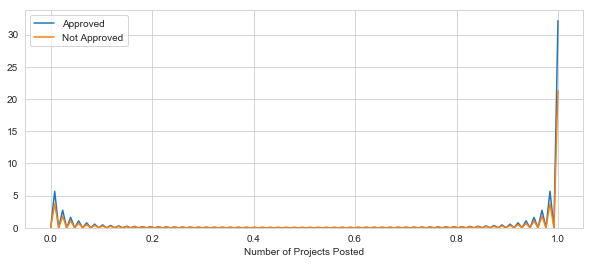

In [76]:
# Kernal density estimation plot.

plt.figure(figsize = (10,4))
sns.distplot(approved_projects_digit, hist=False, label = 'Approved')
sns.distplot(not_approved_projects_digit, hist=False, label = 'Not Approved')
plt.xlabel('Number of Projects Posted')
plt.legend()
plt.show()

### Observations
* There are a total of 93492 summaries with no numericals and 15756 with numericals.
* In the above dist plot we can see the approved projects for numericals is higher almost at 89%.
* And the not approved projets with numericals stand at 11% which really is not an impact.
* We can see some figures below.

In [77]:
app = project['presence_of_digit_resource_summary'][(project['presence_of_digit_resource_summary'] == 1) & (project['project_is_approved'] == 1)].count()
print('The approved projects containing digits: ',app)

The approved projects containing digits:  14090


In [78]:
napp = project['presence_of_digit_resource_summary'][(project['presence_of_digit_resource_summary'] == 1) & (project['project_is_approved'] == 0)].count()
print('The projects not approved that contain digits: ',napp)

The projects not approved that contain digits:  1666


In [79]:
print('Approved percentage when there are digits in summary {:.2f}% and Not Approved are {:.2f}%'.format(app/(app + napp), napp/(app + napp)))

Approved percentage when there are digits in summary 0.89% and Not Approved are 0.11%


# 1.3 Text Preprocessing

### 1.3.1 Project_Title

In [80]:
project['project_title'].head(10)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
5    Flexible Seating for Mrs. Jarvis' Terrific Thi...
6    Chromebooks for Special Education Reading Program
7                                It's the 21st Century
8                      Targeting More Success in Class
9      Just For the Love of Reading--\r\nPure Pleasure
Name: project_title, dtype: object

In [81]:
# Defining our function to remove punctuations and spl chars. 

from bs4 import BeautifulSoup 
import contractions 
import re
from nltk.corpus import stopwords

sw = set(stopwords.words('english'))

def clean_sentence(text):
    text = BeautifulSoup(text, 'lxml').get_text()           # removes html tags such as <br />
    text = text.lower()                                     # converts text to lower case
    text = contractions.fix(text)                           # converts (don't) to (do not)
    text = re.sub('\W+',' ',text)                           # removes all special chars, punc
    text = ' '.join(e for e in text.split() if e not in sw) # removes stopwords
    text = ''.join([i for i in text if not i.isdigit()])    # removes numbers
    text = text.split() 
    text1 = []
    for i in text:
        if "_" in i:
            del i                                           # removes string if it contains '_'
        else:
            text1.append(i)
    text = " ".join(text1) 
    return text

In [82]:
# a new list

processed_title = [clean_sentence(i) for i in project['project_title']]

In [83]:
# checking the output.

processed_title[:10]

['educational support english learners home',
 'wanted projector hungry learners',
 'soccer equipment awesome middle school students',
 'techie kindergarteners',
 'interactive math tools',
 'flexible seating mrs jarvis terrific third graders',
 'chromebooks special education reading program',
 'st century',
 'targeting success class',
 'love reading r npure pleasure']

### 1.3.2 Project_essay

In [84]:
# a sample row

project['essay'][20000]

"My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \\r\\n\\r\\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \\r\\nThey also want to learn through games, my kids don't want to sit and do worksheets. They want to learn to count by jumping and p

In [85]:
processed_essay = [clean_sentence(i) for i in project['essay']]

In [86]:
processed_essay[20000]

'kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism eager beavers always strive work hardest working past limitations r n r nthe materials ones seek students teach title school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore ever felt like ants pants needed groove move meeting kids feel time want able move learn say wobble chairs answer love develop core enhances gross motor turn fine motor skills r nthey also want learn games kids want sit worksheets want learn count jumping playing physical engagement key success number toss color shape mats make happen students forget work fun year old deserves nannan'

# Preparing Categorical, Text, Numerical Data

### Categorical: ---> One hot encoding (some features require binary)

* teacher_prefix
* school_state
* project_grade_category
* cleaned_subject_categories
* project_subject_cleaned_subcategories

### Text:           ---> bow, tfidf, Average w2v, tfidf weighted w2v

* project_title
* essay
* project_resource_summary

### Numerical:  ---> standardization

* teacher_number_of_previously_posted_projects
* price
* quantity

# 1.4.1 Vectorizing Categorical Data

### 1.4.1.1 Cleaned_Subject_Categories

In [87]:
csc_vec = CountVectorizer(vocabulary = list(sorted_sub_cat_dict.keys()), lowercase = False, binary = True)
csc_vec.fit(project['project_subject_cleaned_categories'])
print(csc_vec.get_feature_names())

['Literacy_Language', 'Math_Science', 'Health_Sports', 'SpecialNeeds', 'AppliedLearning', 'Music_TheArts', 'History_Civics', 'Warmth', 'Care_Hunger']


In [88]:
csc_one_hot = csc_vec.transform(project['project_subject_cleaned_categories'])
print(csc_one_hot.shape)

(109248, 9)


In [89]:
# Checking the output

csc_one_hot_d = csc_one_hot.toarray()
csc_one_hot_d[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

### 1.4.1.2 Cleaned_Subject_Subcategories

In [90]:
cssc_vec = CountVectorizer(vocabulary = list(sorted_sub_subcat_dict.keys()), lowercase = False,binary = True)
cssc_vec.fit(project['project_subject_cleaned_subcategories'])
print(cssc_vec.get_feature_names())

['Literacy', 'Mathematics', 'Literature_Writing', 'SpecialNeeds', 'AppliedSciences', 'Health_Wellness', 'VisualArts', 'EnvironmentalScience', 'Gym_Fitness', 'ESL', 'EarlyDevelopment', 'Health_LifeScience', 'History_Geography', 'Music', 'College_CareerPrep', 'Other', 'TeamSports', 'CharacterEducation', 'PerformingArts', 'SocialSciences', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'ForeignLanguages', 'Civics_Government', 'Extracurricular', 'ParentInvolvement', 'FinancialLiteracy', 'CommunityService', 'Economics']


In [91]:
cssc_one_hot = cssc_vec.transform(project['project_subject_cleaned_subcategories'])
print(cssc_one_hot.shape)

(109248, 30)


In [92]:
# Checking the output

cssc_one_hot_d = cssc_one_hot.toarray()
cssc_one_hot_d[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

### 1.4.1.3 School_state

In [93]:
my_counter = Counter()
for i in project['school_state']:
    my_counter.update(i.split())
    
print(my_counter)
print()
print(len(my_counter))

Counter({'CA': 15388, 'TX': 7396, 'NY': 7318, 'FL': 6185, 'NC': 5091, 'IL': 4350, 'GA': 3963, 'SC': 3936, 'MI': 3161, 'PA': 3109, 'IN': 2620, 'MO': 2576, 'OH': 2467, 'LA': 2394, 'MA': 2389, 'WA': 2334, 'OK': 2276, 'NJ': 2237, 'AZ': 2147, 'VA': 2045, 'WI': 1827, 'AL': 1762, 'UT': 1731, 'TN': 1688, 'CT': 1663, 'MD': 1514, 'NV': 1367, 'MS': 1323, 'KY': 1304, 'OR': 1242, 'MN': 1208, 'CO': 1111, 'AR': 1049, 'ID': 693, 'IA': 666, 'KS': 634, 'NM': 557, 'DC': 516, 'HI': 507, 'ME': 505, 'WV': 503, 'NH': 348, 'AK': 345, 'DE': 343, 'NE': 309, 'SD': 300, 'RI': 285, 'MT': 245, 'ND': 143, 'WY': 98, 'VT': 80})

51


In [94]:
ss_vec = CountVectorizer(vocabulary = list(my_counter.keys()), lowercase = False,binary = True)
ss_vec.fit(project['school_state'])
print(ss_vec.get_feature_names())

['IN', 'FL', 'AZ', 'KY', 'TX', 'CT', 'GA', 'SC', 'NC', 'CA', 'NY', 'OK', 'MA', 'NV', 'OH', 'PA', 'AL', 'LA', 'VA', 'AR', 'WA', 'WV', 'ID', 'TN', 'MS', 'CO', 'UT', 'IL', 'MI', 'HI', 'IA', 'RI', 'NJ', 'MO', 'DE', 'MN', 'ME', 'WY', 'ND', 'OR', 'AK', 'MD', 'WI', 'SD', 'NE', 'NM', 'DC', 'KS', 'MT', 'NH', 'VT']


In [95]:
ss_one_hot = ss_vec.transform(project['school_state'])
print(ss_one_hot.shape)

(109248, 51)


In [96]:
# Checking the output

ss_one_hot_d = ss_one_hot.toarray()
ss_one_hot_d[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]], dtype=int64)


### 1.4.1.4 Teacher_Prefix

In [97]:
project['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [98]:
project[['teacher_prefix']].info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 1 columns):
teacher_prefix    109245 non-null object
dtypes: object(1)
memory usage: 853.6+ KB


In [99]:
# there are 3 null values and we ffill them

project['teacher_prefix'].ffill(inplace = True)

In [100]:
b=[] 
for i in project['teacher_prefix'][:]:
    i = i.replace('.','')
    b.append(i)

In [101]:
project['teacher_prefix'] = b

In [102]:
my_counter = Counter()
for i in project['teacher_prefix'][:]:
    my_counter.update(i.split())
    
print(my_counter)
print()
print(len(my_counter))

Counter({'Mrs': 57271, 'Ms': 38956, 'Mr': 10648, 'Teacher': 2360, 'Dr': 13})

5


In [103]:
tp_vec = CountVectorizer(vocabulary = list(my_counter.keys()), lowercase = False)
tp_vec.fit(project['teacher_prefix'])
print(tp_vec.get_feature_names())

['Mrs', 'Mr', 'Ms', 'Teacher', 'Dr']


In [104]:
tp_one_hot = tp_vec.transform(project['teacher_prefix'])
print(tp_one_hot.shape)

(109248, 5)


In [105]:
# Checking the output

tp_one_hot_d = tp_one_hot.toarray()
tp_one_hot_d[:5]

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=int64)

### 1.4.1.5 Project_grade_category

In [106]:
project['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [107]:
a = []
for i in project['project_grade_category'][:]:
    i = i.replace(' ','').replace('-','_')
    a.append(i)

In [108]:
project['project_grade_category'] = a

In [109]:
my_counter = Counter()
for i in project['project_grade_category'][:]:
    my_counter.update(i.split())
    
print(my_counter)
print()
print(len(my_counter))

Counter({'GradesPreK_2': 44225, 'Grades3_5': 37137, 'Grades6_8': 16923, 'Grades9_12': 10963})

4


In [110]:
project['project_grade_category'].head()

0    GradesPreK_2
1       Grades6_8
2       Grades6_8
3    GradesPreK_2
4    GradesPreK_2
Name: project_grade_category, dtype: object

In [111]:
pgc_vec = CountVectorizer(vocabulary = list(my_counter.keys()), binary = True, lowercase=False)
pgc_vec.fit(project['project_grade_category'])
print(pgc_vec.get_feature_names())

['GradesPreK_2', 'Grades6_8', 'Grades3_5', 'Grades9_12']


In [112]:
pgc_one_hot = pgc_vec.transform(project['project_grade_category'].values)
print(pgc_one_hot.shape)

(109248, 4)


In [113]:
# Checking the output

pgc_one_hot_d = pgc_one_hot.toarray()
pgc_one_hot_d[:5]

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=int64)

# 1.4.2 Vectorizing Data

### 1.4.2.1 bow on processed title

In [114]:
bow = CountVectorizer(min_df=10)
title_bow = bow.fit_transform(processed_title)
print(title_bow.shape)

(109248, 3191)


### 1.4.2.2 Tfidf on processed title

In [115]:
tfidf = TfidfVectorizer(min_df = 10)
title_tfidf = tfidf.fit_transform(processed_title)
print(title_tfidf.shape)

(109248, 3191)


### 1.4.2.3 bow on processed essay

In [116]:
essay_bow = bow.fit_transform(processed_essay)
print(essay_bow.shape)

(109248, 16840)


### 1.4.2.4 bow on processed resource summary

In [117]:
project['project_resource_summary'][26]

'My students need 2 ipad minis to enhance learning in all content areas!'

In [118]:
processed_resource_summary = [clean_sentence(i) for i in project['project_resource_summary']]

In [119]:
processed_resource_summary[26]

'students need ipad minis enhance learning content areas'

In [120]:
prs_bow = bow.fit_transform(processed_resource_summary)
print(prs_bow.shape)

(109248, 5652)


### 1.4.2.5 Tfidf on processed essay

In [121]:
essay_tfidf = tfidf.fit_transform(processed_essay) # fit and transform
print(essay_tfidf.shape)

(109248, 16840)


### 1.4.2.6 Tfidf on processed resource summary

In [122]:
tfidf_prs = tfidf.fit_transform(processed_resource_summary)
print(tfidf_prs.shape)

(109248, 5652)


# Average W2V using glove vectors

In [123]:
with open(r'C:\Users\Bharat Bhimshetty\Desktop\Python\Applied AI Course\Assignments\Assignment 2\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

In [124]:
# https://stackoverflow.com/a/40737853/10219869 , slicing a set using itertools.

import itertools 
print(set(itertools.islice(glove_words,5)))

{'braincase', 'rewired', 'facial', 'schlosser', 'animator'}


In [125]:
# AAIC word corpus
len(glove_words)

51510

### 1.4.2.7 Average W2V on Processed title

In [126]:
avg_w2v_pt = []
for i in tqdm(processed_title):
    vec = np.zeros(300)
    count_words = 0
    for j in i.split():
        try:
            if j in glove_words:
                vec += model[j]
                count_words = 1
        except:
            pass
        vec /= count_words
    avg_w2v_pt.append(vec)

100%|██████████| 109248/109248 [00:06<00:00, 17934.20it/s]


In [127]:
print(len(avg_w2v_pt))
print(len(avg_w2v_pt[0]))

109248
300


In [128]:
# fortunately there are no inf or -inf values.

len(np.where(np.isinf(avg_w2v_pt))[0])

0

In [129]:
# We check for any nan values.

len(np.where(np.isnan(avg_w2v_pt))[0]) / 300

784.0

In [130]:
# We convert nan values to zero
# https://stackoverflow.com/a/33490774/10219869

avg_w2v_pt = np.array(avg_w2v_pt)
avg_w2v_pt[np.isnan(avg_w2v_pt)] = 0

In [131]:
# We check for any nan values.

len(np.where(np.isnan(avg_w2v_pt))[0]) / 300

0.0

### 1.4.2.8 Average W2V on Processed essay

In [132]:
avg_w2v_pe = []
for i in tqdm(processed_essay):
    vec = np.zeros(300)
    count_words = 0
    for j in i.split():
        try:
            if j in glove_words:
                vec += model[j] 
                count_words += 1
        except:
            pass
        vec /= count_words
    avg_w2v_pe.append(vec)

100%|██████████| 109248/109248 [03:16<00:00, 555.64it/s]


In [133]:
print(len(avg_w2v_pe))
print()
print(len(avg_w2v_pe[0]))

109248

300


In [134]:
# We check for any inf or -inf values.

len(np.where(np.isinf(avg_w2v_pe))[0])

0

In [135]:
# We check for any nan values.

len(np.where(np.isnan(avg_w2v_pe))[0]) / 300

86.0

In [136]:
# We convert nan values to zero
# https://stackoverflow.com/a/33490774/10219869
avg_w2v_pe = np.array(avg_w2v_pe)
avg_w2v_pe[np.isnan(avg_w2v_pe)] = 0

In [137]:
# We check for any nan values.

len(np.where(np.isnan(avg_w2v_pe))[0]) / 300

0.0

### 1.4.2.9 Average W2V on Processed resource summary

In [138]:
avg_w2v_prs = []
for i in tqdm(processed_resource_summary):
    vec = np.zeros(300)
    count_words = 0
    for j in i.split():
        try:
            if j in glove_words:
                vec += model[j]
                count_words = 1
        except:
            pass
        vec /= count_words
    avg_w2v_prs.append(vec)

100%|██████████| 109248/109248 [00:17<00:00, 6084.00it/s]


In [139]:
print(len(avg_w2v_prs))
print(len(avg_w2v_prs[0]))

109248
300


### 1.4.2.10 Tf-idf Weighted W2V on Processed title

In [140]:
tfidf = TfidfVectorizer()
tfidf.fit(processed_title)
# we are converting a dictionary with word as a key, and the idf as a value
title_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
tfidf_words = set(tfidf.get_feature_names())

In [141]:
tfidf_w2v_pt = []                      # tfidf for each row in cleaned text is stored
for title in tqdm(processed_title):
    vector = np.zeros(300)
    weighted_sum = 0
    for word in title.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            # here we are multiplying idf value(title_dict[j]) and the tf value((i.count(j)/len(i.split())))
            Tfidf = title_dict[word] * (title.count(word) / len(title.split())) # # getting the tfidf value for each word
            vector += (vec * Tfidf)    # calculating tfidf weighted w2v
            weighted_sum += Tfidf
    if weighted_sum != 0:
        vector /= weighted_sum
    tfidf_w2v_pt.append(vector)


100%|██████████| 109248/109248 [00:11<00:00, 9472.64it/s] 


In [142]:
print(len(tfidf_w2v_pt))
print(len(tfidf_w2v_pt[0]))

109248
300


In [143]:
# We check for any inf or -inf.

len(np.where(np.isinf(tfidf_w2v_pt))[0]) / 300

0.0

In [144]:
# We check for any nan values.

len(np.where(np.isnan(tfidf_w2v_pt))[0]) / 300

0.0

### 1.4.2.11 Tf-idf Weighted W2V on Processed essay

In [145]:
tfidf = TfidfVectorizer()
tfidf.fit(processed_essay)
# we are converting a dictionary with word as a key, and the idf as a value
essay_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
essay_words = set(tfidf.get_feature_names())

In [146]:
tfidf_w2v_pe = []                      # tfidf for each row in cleaned text is stored
for essay in tqdm(processed_essay):
    vector = np.zeros(300)
    weighted_sum = 0
    for word in essay.split():
        if (word in glove_words) and (word in essay_words):
            vec = model[word]
            # here we are multiplying idf value(title_dict[j]) and the tf value((i.count(j)/len(i.split())))
            Tfidf = essay_dict[word] * (essay.count(word) / len(essay.split())) # # getting the tfidf value for each word
            vector += (vec * Tfidf)    # calculating tfidf weighted w2v
            weighted_sum += Tfidf
    if weighted_sum != 0:
        vector /= weighted_sum
    tfidf_w2v_pe.append(vector)


100%|██████████| 109248/109248 [08:33<00:00, 212.57it/s]


In [147]:
print(len(tfidf_w2v_pe))
print()
print(len(tfidf_w2v_pe[0]))

109248

300


In [148]:
# We check for any inf or -inf.

len(np.where(np.isinf(tfidf_w2v_pe))[0]) / 300

0.0

In [149]:
# We check for any nan values.

len(np.where(np.isnan(tfidf_w2v_pe))[0]) / 300

0.0

### 1.4.3 Vectorizing Numerical features

### 1.4.3.1 price standardization

In [150]:
price_scale = StandardScaler()
price_scale.fit(project_resource['price'].values.reshape(-1,1)) # we want (1 column and unknown row)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [151]:
mean = price_scale.mean_
std = np.sqrt(price_scale.var_)
print(f'Mean: {np.around(mean)} and Standard deviation {np.around(std)}')

Mean: [298.] and Standard deviation [367.]


In [152]:
# we standardize the data with above mean and variance

price_standardized = price_scale.transform(project_resource['price'].values.reshape(-1,1))

In [153]:
# Checking the output

price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

### 1.4.3.2 teacher number of previously posted projects - standardization

In [154]:
tnppp_scale = StandardScaler()
tnppp_scale.fit(project_resource['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

C:\Desktop\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



StandardScaler(copy=True, with_mean=True, with_std=True)

In [155]:
print(f'Mean: {np.round(tnppp_scale.mean_)} and Standard deviation: {np.round(np.sqrt(tnppp_scale.var_))}')

Mean: [11.] and Standard deviation: [28.]


In [156]:
tnppp_standardized = tnppp_scale.transform(project_resource['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

C:\Desktop\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [157]:
# Checking the output

tnppp_standardized

array([[-0.40152481],
       [-0.14951799],
       [-0.36552384],
       ...,
       [-0.29352189],
       [-0.40152481],
       [-0.40152481]])

### 1.4.3.3 quantity standardization

In [158]:
quantity_scale = StandardScaler()
quantity_scale.fit(project_resource['quantity'].values.reshape(-1,1))

C:\Desktop\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



StandardScaler(copy=True, with_mean=True, with_std=True)

In [159]:
print(f'Mean: {np.round(quantity_scale.mean_)} and Standard deviation: {np.round(np.sqrt(quantity_scale.var_))}')

Mean: [17.] and Standard deviation: [26.]


In [160]:
quantity_standardized = quantity_scale.transform(project_resource['quantity'].values.reshape(-1,1))

C:\Desktop\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [161]:
# Checking the output

quantity_standardized

array([[ 0.23047132],
       [-0.60977424],
       [ 0.19227834],
       ...,
       [-0.4951953 ],
       [-0.03687954],
       [-0.45700232]])

# 1.4.4 Merging the above features

In [162]:
print(csc_one_hot.shape, ': Cleaned subject caterogies')
print(cssc_one_hot.shape, ': Cleaned subject subcaterogies')
print(ss_one_hot.shape, ': School state')
print(tp_one_hot.shape, ': Teacher prefix')
print(pgc_one_hot.shape, ': Project grade category')
print(title_bow.shape, ': Processed Title BOW')
print(title_tfidf.shape, ': Processed Title Tfidf')
print(len(avg_w2v_pt), ': Processed Title Avg W2V')
print(len(tfidf_w2v_pt), ': Processed Title Tfidf Weighted W2V')
print(price_standardized.shape, ': Price Standardization')
print(tnppp_standardized.shape, ': Teacher numper of previously posted projects Standardization')

(109248, 9) : Cleaned subject caterogies
(109248, 30) : Cleaned subject subcaterogies
(109248, 51) : School state
(109248, 5) : Teacher prefix
(109248, 4) : Project grade category
(109248, 3191) : Processed Title BOW
(109248, 3191) : Processed Title Tfidf
109248 : Processed Title Avg W2V
109248 : Processed Title Tfidf Weighted W2V
(109248, 1) : Price Standardization
(109248, 1) : Teacher numper of previously posted projects Standardization


<h1><font color='red'>Assignment 2: Apply TSNE<font></h1>

<ol> 
    <li> In the above cells we have plotted and analyzed many features. Please observe the plots and write the observations in markdown cells below every plot.</li>
    <li> EDA: Please complete the analysis of the feature: teacher_number_of_previously_posted_projects</li>
    <li>
        <ul>Build the data matrix using these features 
            <li>school_state : categorical data (one hot encoding)</li>
            <li>clean_categories : categorical data (one hot encoding)</li>
            <li>clean_subcategories : categorical data (one hot encoding)</li>
            <li>teacher_prefix : categorical data (one hot encoding)</li>
            <li>project_grade_category : categorical data (one hot encoding)</li>
            <li>project_title : text data (BOW, TFIDF, AVG W2V, TFIDF W2V)</li>
            <li>price : numerical</li>
            <li>teacher_number_of_previously_posted_projects : numerical</li>
         </ul>
    </li>
    <li> Now, plot FOUR t-SNE plots with each of these feature sets.
        <ol>
            <li>categorical, numerical features + project_title(BOW)</li>
            <li>categorical, numerical features + project_title(TFIDF)</li>
            <li>categorical, numerical features + project_title(AVG W2V)</li>
            <li>categorical, numerical features + project_title(TFIDF W2V)</li>
        </ol>
    </li>
    <li> Concatenate all the features and Apply TNSE on the final data matrix </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points to avoid memory issues. If you run into memory error issues, reduce the number of data points but clearly state the number of datat-poins you are using</font></li>
</ol>

<h2><font color = 'purple'> 2.1 TSNE with `BOW` encoding of `project_title` feature </h2>

In [163]:
# hstack of numerical (2) featurs and categorical features (5), Project_title BOW (1)

from scipy.sparse import hstack

title_bow = title_bow.tocsr()
x_title_bow = hstack((csc_one_hot, cssc_one_hot, ss_one_hot, tp_one_hot, pgc_one_hot, price_standardized, tnppp_standardized, title_bow))
x_title_bow.shape

(109248, 3292)

In [164]:
# https://stackoverflow.com/a/30175105/10219869 (matrix 'x' output is coo_matrix (coordinate format) 
# and we need to convert to csr_matrix (compressed sparse row format))
# Then we apply T-SNE


from sklearn.manifold import TSNE
tsne = TSNE()

x_title_bow = x_title_bow.tocsr()
x_bow5000 = x_title_bow[:5000]
tsne_title_bow = tsne.fit_transform(x_bow5000.toarray())

# bringing x_title_bow (3292) dimentions to 2 dimentions

tsne_title_bow.shape 

(5000, 2)

In [165]:
# https://stackoverflow.com/a/41989993/10219869
    
bow_tsne = np.column_stack((tsne_title_bow, project['project_is_approved'][:5000]))
bow_tsne.shape

(5000, 3)

In [166]:
# We create a dataframe for 2 dimentions and a binary class label.

df_bow = pd.DataFrame(bow_tsne, columns = ['Dimention1', 'Dimention2', 'Project_approved_unapproved'])
df_bow.head()

Dimention1  Dimention2  Project_approved_unapproved
0  -48.135483   12.628063                          0.0
1   48.738190  -26.293175                          1.0
2   41.727901  -24.581388                          0.0
3  -20.768230   46.092354                          1.0
4    9.088734   27.165798                          1.0

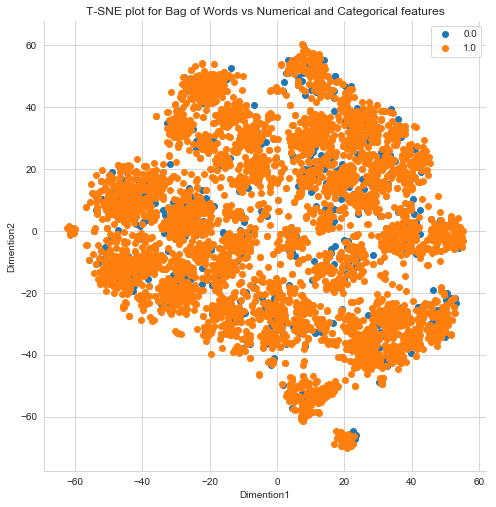

In [167]:
# We design T-SNE for first 5000 datapoints.

sns.FacetGrid(df_bow, hue = 'Project_approved_unapproved', height = 7).map(plt.scatter, 'Dimention1', 'Dimention2')
plt.title('T-SNE plot for Bag of Words vs Numerical and Categorical features')
plt.legend()
plt.show()

### Observations
* The orange color depicts that projects are approved and assigned class label is 1. And for blue color it is projects not approved and assigned class label is 0.
* We can observe the points in BOW T-SNE are formed in clusters which are close to each other and are overlapped with blue dots..

<h2><font color = 'purple'> 2.2 TSNE with `TFIDF` encoding of `project_title` feature </h2>

In [168]:
# hstack of numerical (2) featurs and categorical (5) features , Project_title Tfidf (1)

title_tfidf = title_tfidf.tocsr()
x_title_tfidf = hstack((csc_one_hot, cssc_one_hot, ss_one_hot, tp_one_hot, pgc_one_hot, price_standardized, tnppp_standardized, title_tfidf))
x_title_tfidf.shape

(109248, 3292)

In [169]:
# https://stackoverflow.com/a/30175105/10219869 (matrix 'x' output is coo_matrix (coordinate format) 
# and we need to convert to csr_matrix (compressed sparse row format))
# Then we apply T-SNE

x_title_tfidf = x_title_tfidf.tocsr()
x_tfidf5000 = x_title_tfidf[:5000]
tsne_title_tfidf = tsne.fit_transform(x_tfidf5000.toarray())

# bringing x_title_tfidf (3292) dimentions to 2 dimentions

tsne_title_tfidf.shape 

(5000, 2)

In [170]:
# https://stackoverflow.com/a/41989993/10219869
    
tfidf_tsne = np.column_stack((tsne_title_tfidf, project['project_is_approved'][:5000]))
tfidf_tsne.shape

(5000, 3)

In [171]:
# We create a dataframe with 2 dimentions and a binary class label.

df_tfidf = pd.DataFrame(tfidf_tsne, columns = ['Dimention1', 'Dimention2', 'Project_approved_unapproved'])
df_tfidf.head()

Dimention1  Dimention2  Project_approved_unapproved
0   69.691498    0.144981                          0.0
1  -61.891365  -18.266775                          1.0
2  -55.515419  -21.190441                          0.0
3   63.076767   30.725538                          1.0
4   -6.787931   59.004528                          1.0

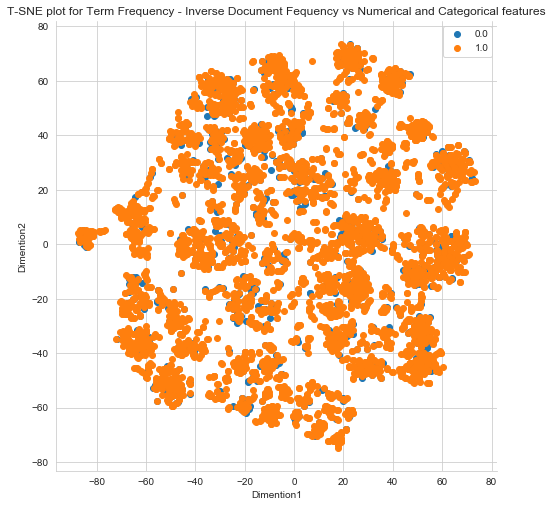

In [172]:
# We design T-SNE for first 5000 datapoints.

sns.FacetGrid(df_tfidf, hue = 'Project_approved_unapproved', height = 7).map(plt.scatter, 'Dimention1', 'Dimention2')
plt.title('T-SNE plot for Term Frequency - Inverse Document Fequency vs Numerical and Categorical features')
plt.legend()
plt.show()

### Observations
* The orange color depicts that projects are approved and assigned class label is 1. And for blue color it is projects not approved and assigned class label is 0.
* We can observe the points in Tfidf T-SNE are scattered and are overlapped but we can see some clusters not that dense as previouss.

<h2><font color = 'purple'> 2.3 TSNE with `Average W2V` encoding of `project_title` feature </h2>

In [173]:
# hstack of numerical (2) features and categorical (5) features , Project_title Average W2V (1)

avg_w2v_pt = np.array(avg_w2v_pt)
x_title_AvgW2V = hstack((csc_one_hot, cssc_one_hot, ss_one_hot, tp_one_hot, pgc_one_hot, price_standardized, tnppp_standardized, avg_w2v_pt))
x_title_AvgW2V.shape

(109248, 401)

In [174]:
# https://stackoverflow.com/a/30175105/10219869 (matrix 'x' output is coo_matrix (coordinate format) 
# and we need to convert to csr_matrix (compressed sparse row format))
# Then we apply T-SNE

x_title_AvgW2V = x_title_AvgW2V.tocsr()
x_AvgW2V5000 = x_title_AvgW2V[:5000]
tsne_title_AvgW2V = tsne.fit_transform(x_AvgW2V5000.toarray())

# bringing x_title_AvgW2V (401) dimentions to 2 dimentions

tsne_title_AvgW2V.shape 

(5000, 2)

In [175]:
# https://stackoverflow.com/a/41989993/10219869
    
avg_w2v_tsne = np.column_stack((tsne_title_AvgW2V, project['project_is_approved'][:5000]))
avg_w2v_tsne.shape

(5000, 3)

In [176]:
# We create a dataframe with 2 dimentions and a binary class label.

df_avg_w2v = pd.DataFrame(avg_w2v_tsne, columns = ['Dimention1', 'Dimention2', 'Project_approved_unapproved'])
df_avg_w2v.head()

Dimention1  Dimention2  Project_approved_unapproved
0   40.590145   46.245464                          0.0
1  -41.724751   -2.392165                          1.0
2   -0.911976   66.311897                          0.0
3   11.257945  -61.307606                          1.0
4   28.081192   -8.649153                          1.0

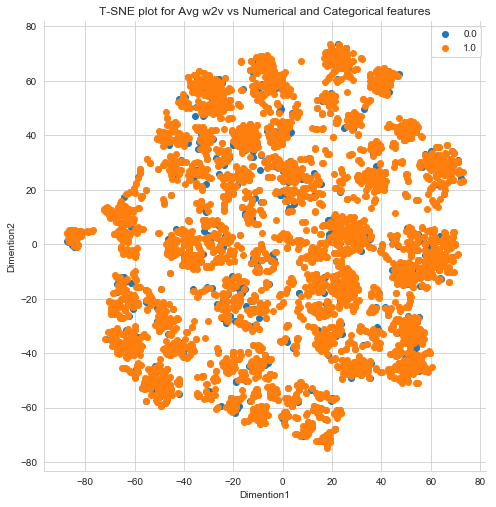

In [177]:
# We design T-SNE for first 5000 datapoints.

sns.FacetGrid(df_tfidf, hue = 'Project_approved_unapproved', height = 7).map(plt.scatter, 'Dimention1', 'Dimention2')
plt.title('T-SNE plot for Avg w2v vs Numerical and Categorical features')
plt.legend()
plt.show()

### Observations
* The orange color depicts that projects are approved and assigned class label is 1. And for blue color it is projects not approved and assigned class label is 0.
* We can observe the points in Average W2V T-SNE are scattered and are overlapped but we can see clusters almost similar to  Tfidf.

<h2><font color = 'purple'> 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

In [178]:
# hstack of numerical (2) features and categorical (5) features , Project_title Tfidf weighted W2V (1)

x_tfidf_w_w2v = np.array(tfidf_w2v_pt)
x_title_tfidfwW2V = hstack((csc_one_hot, cssc_one_hot, ss_one_hot, tp_one_hot, pgc_one_hot, price_standardized, tnppp_standardized, x_tfidf_w_w2v))
x_title_tfidfwW2V.shape

(109248, 401)

In [179]:
# https://stackoverflow.com/a/30175105/10219869 (matrix 'x' output is coo_matrix (coordinate format) 
# and we need to convert to csr_matrix (compressed sparse row format))
# Then we apply T-SNE

x_title_tfidfwW2V = x_title_tfidfwW2V.tocsr()
x_tfidfwW2V5000 = x_title_tfidfwW2V[:5000]
tsne_title_tfidfwW2V = tsne.fit_transform(x_tfidfwW2V5000.toarray())

# bringing x_title_tfidfwW2V (401) dimentions to 2 dimentions

tsne_title_tfidfwW2V.shape 

(5000, 2)

In [180]:
# https://stackoverflow.com/a/41989993/10219869
    
tfidf_w2v_tsne = np.column_stack((tsne_title_tfidfwW2V, project['project_is_approved'][:5000]))
tfidf_w2v_tsne.shape

(5000, 3)

In [181]:
# We create a dataframe with 2 dimentions and a binary class label.

df_tfidf_w_w2v = pd.DataFrame(tfidf_w2v_tsne, columns = ['Dimention1', 'Dimention2', 'Project_approved_unapproved'])
df_tfidf_w_w2v.head()

Dimention1  Dimention2  Project_approved_unapproved
0   38.569233   -3.012925                          0.0
1  -30.473494   54.201756                          1.0
2  -37.659996   55.101582                          0.0
3   25.728868  -33.869778                          1.0
4   11.121451  -45.624763                          1.0

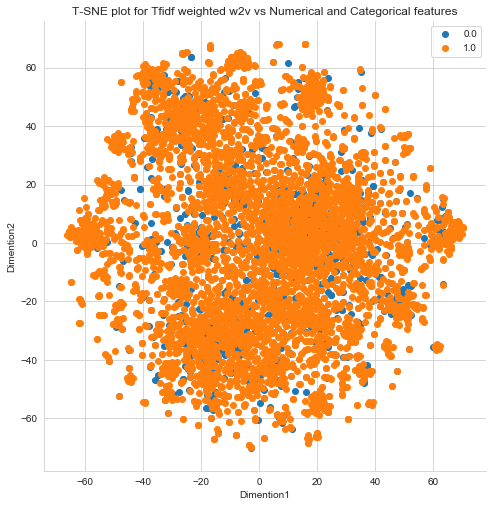

In [182]:
# We design T-SNE for first 5000 datapoints.

sns.FacetGrid(df_tfidf_w_w2v, hue = 'Project_approved_unapproved', height = 7).map(plt.scatter, 'Dimention1', 'Dimention2')
plt.title('T-SNE plot for Tfidf weighted w2v vs Numerical and Categorical features')
plt.legend()
plt.show()

### Observations
* The orange color depicts that projects are approved and assigned class label is 1. And for blue color it is projects not approved and assigned class label is 0.
* We can observe the points in Weighted W2V T-SNE are scattered and are overlapped worse than Average Tfidf.

<h2><font color = 'purple'> 2.5 TSNE with 'BOW', 'TFIDF', 'AVG W2V', `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

In [183]:
# hstack of numerical (2) features and categorical (5) features , Project_title Tfidf weighted W2V (1)

x_title_all = hstack((csc_one_hot, cssc_one_hot, ss_one_hot, tp_one_hot, pgc_one_hot, price_standardized, tnppp_standardized, title_bow, title_tfidf, avg_w2v_pt, x_tfidf_w_w2v))
x_title_all.shape

(109248, 7083)

In [184]:
# https://stackoverflow.com/a/30175105/10219869 (matrix 'x' output is coo_matrix (coordinate format) 
# and we need to convert to csr_matrix (compressed sparse row format))
# Then we apply T-SNE

x_title_all = x_title_all.tocsr()
x_all5000 = x_title_all[:5000]
tsne_title_all = tsne.fit_transform(x_all5000.toarray())

# bringing x_title_tfidfwW2V (401) dimentions to 2 dimentions

tsne_title_all.shape 

(5000, 2)

In [185]:
# https://stackoverflow.com/a/41989993/10219869
    
all_tsne = np.column_stack((tsne_title_all, project['project_is_approved'][:5000]))
all_tsne.shape

(5000, 3)

In [186]:
# We create a dataframe with 2 dimentions and a binary class label.

df_title_all = pd.DataFrame(all_tsne, columns = ['Dimention1', 'Dimention2', 'Project_approved_unapproved'])
df_title_all.head()

Dimention1  Dimention2  Project_approved_unapproved
0  -29.750196  -27.330162                          0.0
1   -1.696946   54.051628                          1.0
2  -52.176514   18.111908                          0.0
3   54.596596  -15.566402                          1.0
4    6.802349  -30.261414                          1.0

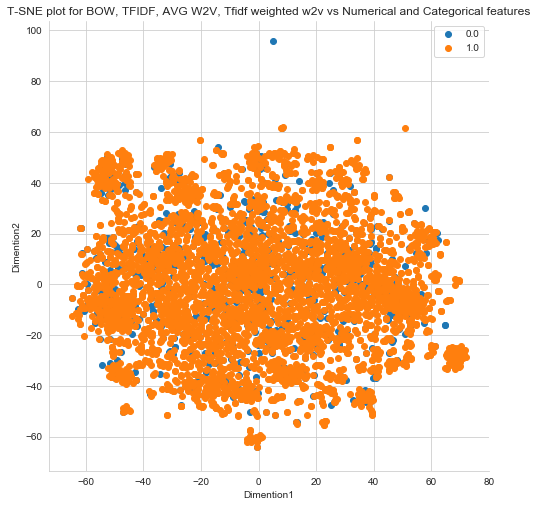

In [187]:
# We design T-SNE for first 5000 datapoints.

sns.FacetGrid(df_title_all, hue = 'Project_approved_unapproved', height = 7).map(plt.scatter, 'Dimention1', 'Dimention2')
plt.title('T-SNE plot for BOW, TFIDF, AVG W2V, Tfidf weighted w2v vs Numerical and Categorical features')
plt.legend()
plt.show()

### Observations
* The orange color depicts that projects are approved and assigned class label is 1. And for blue color it is projects not approved and assigned class label is 0.
* We can observe the points when we mix up the BOW, TFIDF, AVG W2V, Weighted W2V, the T-SNE are mixed up and are overlapped worse than Tfidf weighted W2V.

# Conclusion
* The T-SNE plot with TFIDF and Avg W2V can be considered apart from other T-SNE's as there are clusters and not much overlapped.